In [3]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [16]:
# 生成带有噪声的线性模型的人造数据集
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w))) #  torch.normal() 函数生成一个形状为 (num_examples, len(w)) 的随机数张量 X，其中每个元素都是从均值为 0、标准差为 1 的正态分布中采样得到的
    y = torch.matmul(X, w) + b
    # print(X.shape, y.shape, torch.matmul(X, w).shape)
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1)) # 将y转换为一个列向量

true_w = torch.tensor([2., -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print("features[0]: ", features[0], "\nlabels:", labels[0])


torch.Size([1000, 2]) torch.Size([1000]) torch.Size([1000])
features[0]:  tensor([ 1.7245, -0.2740]) 
labels: tensor([8.5685])


In [13]:
print(features.shape)
print(true_w.shape)
print(labels.shape)

torch.Size([1000, 2])
torch.Size([2])
torch.Size([1000, 1])


In [29]:
y = torch.tensor([1, 2, 3, 4, 5])
print(y.shape)
y_reshaped = y.reshape((-1, 1))
print(y_reshaped.shape)

torch.Size([5])
torch.Size([5, 1])


In [32]:
# 矩阵与向量乘法示例
M = torch.tensor([[1, 2, 3], [4, 5, 6]])
# torh.tensor创建的是行变量
v = torch.tensor([7, 8, 9])

result = torch.matmul(M, v)
print(result)

M = torch.tensor([[1, 2, 3],
            [4, 5, 6]])

v = torch.tensor([7, 8, 9])

# 广播 （broadcasting） v 为 (3, 1) 的二维张量
v_broadcasted = torch.tensor([[7],
                        [8],
                        [9]])
result = torch.matmul(M, v_broadcasted)
print(result)

tensor([ 50, 122])
tensor([[ 50],
        [122]])


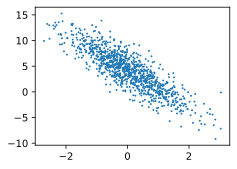

In [33]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), #作用是将张量 features 的所有行和第 1 列的子张量提取出来，并将其转换为 NumPy 数组。请注意，这个操作将返回一个不可训练的、与原始张量共享数据的 NumPy 数组。
                labels.detach().numpy(), 1)

In [37]:
# 批量接收数据，生成一个大小为batch_size的小批量
def data_iter(batch_size, features, labels):
    num_examplpes = len(features)
    indices = list(range(num_examplpes))
    random.shuffle(indices)
    for i in range(0, num_examplpes, batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size, num_examplpes)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10
# 打印每个batch的数据和label， 并不是一个一个样本打印的
for i, (X, y) in enumerate(data_iter(batch_size, features, labels)):
    print(i)
    print(X, '\n', y)
    print("=====================================")

0
tensor([[ 0.2196, -0.2083],
        [-1.0397,  0.7725],
        [-0.4830, -0.6119],
        [ 1.0755,  0.3058],
        [-0.3022,  0.7146],
        [-0.5508,  0.5185],
        [-0.1596,  0.5302],
        [-0.3037,  1.0388],
        [-1.0377,  0.1883],
        [-0.8757, -0.1498]]) 
 tensor([[ 5.3413],
        [-0.5121],
        [ 5.3275],
        [ 5.2984],
        [ 1.1764],
        [ 1.3407],
        [ 2.0685],
        [ 0.0642],
        [ 1.4816],
        [ 2.9376]])
1
tensor([[-1.2814,  0.8644],
        [ 0.6512,  2.1788],
        [-0.0794,  0.5387],
        [-2.4227,  0.6929],
        [ 2.0414,  1.1489],
        [ 1.1972,  0.3551],
        [-0.4488,  0.4013],
        [-0.5176,  3.0342],
        [-1.7958, -0.3660],
        [-0.5122,  0.7883]]) 
 tensor([[-1.3113],
        [-1.8945],
        [ 2.2014],
        [-2.9792],
        [ 4.3716],
        [ 5.3824],
        [ 1.9591],
        [-7.1596],
        [ 1.8404],
        [ 0.4906]])
2
tensor([[-0.7827, -0.2355],
        [ 0.7999, 

In [40]:
# 初始化模型的参数w, b
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [39]:
# 定义模型
def linreg(X, w, b):
    return torch.matmul(X, w) + b

In [38]:
# 定义损失函数
def squared_loss(y_hat, y):
    return (y_hat-y.reshape(y_hat.shape))**2/2

In [44]:
# 定义优化算法
def sgd(params, lr, batch_size):
    '小批量随机梯度下降'
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()


In [51]:
# 训练过程
lr = 0.03
num_epoches = 3
net = linreg
loss = squared_loss

for epoch in range(num_epoches):
    for X, y in data_iter(batch_size, features, labels):
        '每个batch的总体误差损失， 然后计算每个batch的梯度下降'
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad(): # 上下文管理器，用于是否跟踪梯度信息，表示不计算梯度，提高代码的执行效率，较少内存消耗
        '利用当前参数跑一边所有的训练数据，看一下整体的loss'
        '每个 epoch 结束后，可以进行一些评估操作（例如计算训练集或验证集上的损失或准确率），或者保存模型的中间结果，以便后续使用和分析。外部循环还可以用于控制训练的停止条件'
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.000049
epoch 2, loss 0.000050
epoch 3, loss 0.000049


In [52]:
# 比较真实参数与训练得到的参数
print("训练参数\n", w,'\n', b)
print("真实参数\n", true_w,'\n', true_b)
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b - b}')

训练参数
 tensor([[ 1.9993],
        [-3.3993]], requires_grad=True) 
 tensor([4.2000], requires_grad=True)
真实参数
 tensor([ 2.0000, -3.4000]) 
 4.2
w的估计误差：tensor([ 0.0007, -0.0007], grad_fn=<SubBackward0>)
b的估计误差：tensor([4.8161e-05], grad_fn=<RsubBackward1>)


## 下面是简洁实现

In [53]:
import numpy as np 
import torch
from torch.utils import data
from d2l import torch as d2l


In [66]:
true_w = torch.tensor([2., -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)


In [67]:
# 调用框架中现有的API进行读取数据
def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    # print(dataset)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)
next(iter(data_iter))


[tensor([[ 0.6583,  2.2387],
         [-1.6899,  0.0275],
         [-0.4498, -0.2790],
         [-1.2361,  0.5942],
         [-0.4004, -0.2982],
         [ 2.3870, -0.6968],
         [-0.4655,  1.1099],
         [-0.8518,  1.7268],
         [ 1.2248,  1.6575],
         [-0.8962, -0.4654]]),
 tensor([[-2.0950],
         [ 0.7286],
         [ 4.2464],
         [-0.2972],
         [ 4.4182],
         [11.3662],
         [-0.5186],
         [-3.3680],
         [ 1.0027],
         [ 3.9983]])]

In [68]:
# 使用框架的预定义好的层
from torch import nn
net = nn.Sequential(nn.Linear(2,1))

In [69]:
# 设置模型的初始参数
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [70]:
# 使用均方误差，即L2范数
loss = nn.MSELoss()

In [71]:
# 实例化SGD
trainer = torch.optim.SGD(net.parameters(), lr = 0.03) # is typically an optimizer object like

In [75]:
# 训练代码
num_epochs = 3
for epoch in range(num_epoches):
    for X, y in data_iter:
        l = loss(net(X), y)
        # Reset gradients to zero; PyTorch accumulates gradients otherwise
        trainer.zero_grad() # Before you can calculate the new gradients, you need to set the existing gradients to zero. In PyTorch, gradients accumulate by default, so you need to explicitly set them to zero before starting the backpropagation
        # Backpropagate loss
        l.backward() # It calculates the gradient of the loss with respect to all parameters in the network,After this call, all parameters will have .grad attributes that contain their gradients with respect to the loss.
        # Update model parameters
        trainer.step() # updates the parameters of the neural network based on the gradients
    l = loss(net(features), labels)
    print(f'epoch {epoch +1}, loss {l:f}')

epoch 1, loss 0.000273
epoch 2, loss 0.000101
epoch 3, loss 0.000101


In [76]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([ 9.8944e-05, -4.6015e-05])
b的估计误差： tensor([-0.0002])


### 联系总结
* 对于tensor的操作不是很熟练
* 对于torch.matmul中矩阵乘法没有遵循数学中的维度规定感到疑惑, 可能是广播的效果
* 感觉听完之后再练习可能效果没有那么好, 但是边听课边练习可能时间会更久, 下次可能回尝试听完整节课后进行练习